### Scoutium - Makine Öğrenmesi ile Yetenek Avcılığı Sınıflandırma 

**İş Problemi**

Scoutium, dijital bir futbol gözlem platformudur. Bu platform, futbolcuların performansını değerlendirerek yetenekli oyuncuları keşfetmeyi ve futbol kulüplerine sunmayı amaçlamaktadır. Projenin hedefi, Scout'lar tarafından izlenen futbolcuların özelliklerine dayanarak, bu futbolcuların hangi kategoriye (ortalama veya ön plana çıkan) girdiğini tahmin etmektir.

**Veri Seti Hikayesi**

Veri seti Scoutium’dan maçlarda gözlemlenen futbolcuların özelliklerine göre scoutların değerlendirdikleri futbolcuların, maç
içerisinde puanlanan özellikleri ve puanlarını içeren bilgilerden oluşmaktadır.

**Değişkenler**

**task_response_id:** Bir scoutun bir maçta bir takımın kadrosundaki tüm oyunculara dair değerlendirmelerinin kümesi

**match_id:** İlgili maçın id'si

**evaluator_id:** Değerlendiricinin (scout'un) id'si

**player_id:** İlgili oyuncunun id'si

**position_id:** İlgili oyuncunun o maçta oynadığı pozisyonun id’si

- 1: Kaleci
- 2: Stoper
- 3: Sağ bek
- 4: Sol bek
- 5: Defansif orta saha
- 6: Merkez orta saha
- 7: Sağ kanat
- 8: Sol kanat
- 9: Ofansif orta saha
- 10: Forvet

**analysis_id:** Bir scoutun bir maçta bir oyuncuya dair özellik değerlendirmelerini içeren küme

**attribute_id:** Oyuncuların değerlendirildiği her bir özelliğin id'si

**attribute_value:** Bir scoutun bir oyuncunun bir özelliğine verdiği değer (puan)

**potential_label:** Bir scoutun bir maçta bir oyuncuyla ilgili nihai kararını belirten etiket. (hedef değişken)

**Adım 1:** scoutium_attributes.csv ve scoutium_potential_labels.csv dosyalarını okutunuz.

In [1]:
# Gerekli Kütüphane ve Fonksiyonların Kurulması

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = "ignore", category = ConvergenceWarning)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

df1 = pd.read_csv("datasets/scoutium_attributes.csv", delimiter = ";")

df2 = pd.read_csv("datasets/scoutium_potential_labels.csv", delimiter = ";")

**Adım 2:** Okutmuş olduğumuz csv dosyalarını merge fonksiyonunu kullanarak birleştiriniz. ("task_response_id", "match_id", "evaluator_id", "player_id" olmak üzere 4 adet değişken üzerinden birleştirme işlemini gerçekleştiriniz).

In [2]:
df = pd.merge(df1, df2, on = ['task_response_id', 'match_id', 'evaluator_id', 'player_id'])

df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


In [3]:
df.shape

(10730, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10730 entries, 0 to 10729
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   task_response_id  10730 non-null  int64  
 1   match_id          10730 non-null  int64  
 2   evaluator_id      10730 non-null  int64  
 3   player_id         10730 non-null  int64  
 4   position_id       10730 non-null  int64  
 5   analysis_id       10730 non-null  int64  
 6   attribute_id      10730 non-null  int64  
 7   attribute_value   10730 non-null  float64
 8   potential_label   10730 non-null  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 754.6+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
task_response_id,10730.000,5252.082,268.254,4915.000,4997.000,5162.000,5524.000,5642.000
match_id,10730.000,63199.764,663.917,60549.000,62988.000,63166.000,63627.000,64045.000
evaluator_id,10730.000,175246.880,43667.459,130478.000,151191.000,151191.000,177676.000,256441.000
player_id,10730.000,1525548.486,201751.875,1355710.000,1367783.000,1372670.000,1719053.000,1909728.000
position_id,10730.000,5.347,2.861,1.000,3.000,6.000,8.000,10.000
analysis_id,10730.000,12822388.800,2676.866,12818481.000,12819582.000,12822231.000,12825047.000,12825764.000
attribute_id,10730.000,4348.609,26.980,4322.000,4330.000,4342.000,4353.000,4426.000
attribute_value,10730.000,55.271,16.048,1.000,45.000,56.000,67.000,100.000


**Adım 3:** position_id içerisindeki Kaleci (1) sınıfını veri setinden kaldırınız.

In [6]:
# Sanırım kaleci ihtiyacı olmayan bir takım için hizmet verdiğimizi düşünüyoruz.

In [7]:
df.drop(df[df["position_id"] == 1].index, inplace = True) 

In [8]:
df["position_id"].value_counts()

position_id
2     1972
6     1428
10    1088
8     1020
7      986
3      986
4      884
9      850
5      816
Name: count, dtype: int64

**Adım 4:** potential_label içerisindeki below_average sınıfını veri setinden kaldırınız. (below_average sınıfı tüm verisetinin %1'ini oluşturur.)

In [9]:
# potentional_label sütununda below_average sınıfının yoğunluğu çok düşük. 

In [10]:
df.drop(df[df["potential_label"] == "below_average"].index, inplace = True)

In [11]:
df["potential_label"].value_counts()

potential_label
average        7922
highlighted    1972
Name: count, dtype: int64

**Adım 5:** Oluşturduğunuz veri setinden “pivot_table” fonksiyonunu kullanarak bir tablo oluşturunuz. Bu pivot table'da her satırda bir oyuncu olacak şekilde manipülasyon yapınız.

**Adım 5.1:** İndekste “player_id”, “position_id” ve “potential_label”, sütunlarda “attribute_id” ve değerlerde scout’ların oyunculara verdiği puan “attribute_value” olacak şekilde pivot table’ı oluşturunuz.

<img src = "images/pivot_table.png" style = "width:1050px; height:200px"/>

**Adım 5.2:** “reset_index” fonksiyonunu kullanarak indeksleri değişken olarak atayınız ve “attribute_id” sütunlarının isimlerini stringe çeviriniz.

In [12]:
df_table = df.pivot_table(index = ["player_id", "position_id", "potential_label"], columns = "attribute_id", values = "attribute_value")

df_table = df_table.reset_index()

df_table.columns = df_table.columns.map(str)

df_table.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,...,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,...,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,...,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,...,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,...,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


In [13]:
df_table.shape

(271, 37)

In [14]:
df_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   player_id        271 non-null    int64  
 1   position_id      271 non-null    int64  
 2   potential_label  271 non-null    object 
 3   4322             271 non-null    float64
 4   4323             271 non-null    float64
 5   4324             271 non-null    float64
 6   4325             271 non-null    float64
 7   4326             271 non-null    float64
 8   4327             271 non-null    float64
 9   4328             271 non-null    float64
 10  4329             271 non-null    float64
 11  4330             271 non-null    float64
 12  4332             271 non-null    float64
 13  4333             271 non-null    float64
 14  4335             271 non-null    float64
 15  4338             271 non-null    float64
 16  4339             271 non-null    float64
 17  4340            

**Adım 6:** Label Encoder fonksiyonunu kullanarak “potential_label” kategorilerini (average, highlighted) sayısal olarak ifade ediniz.

In [15]:
def grab_col_names(dataframe, cat_th = 10, car_th = 20):
    
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = değişken sayısı.
    # num_but_cat cat_cols'un içerisinde zaten.
    # dolayısıyla tüm şu 3 liste ile tüm değişkenler seçilmiş olacaktır: cat_cols + num_cols + cat_but_car
    # num_but_cat sadece raporlama için verilmiştir.

    return cat_cols, cat_but_car, num_cols

In [16]:
cat_cols, cat_but_car, num_cols = grab_col_names(df_table)

Observations: 271
Variables: 37
cat_cols: 7
num_cols: 30
cat_but_car: 0
num_but_cat: 6


In [17]:
cat_cols

['potential_label', 'position_id', '4324', '4328', '4352', '4357', '4423']

In [18]:
num_cols

['player_id',
 '4322',
 '4323',
 '4325',
 '4326',
 '4327',
 '4329',
 '4330',
 '4332',
 '4333',
 '4335',
 '4338',
 '4339',
 '4340',
 '4341',
 '4342',
 '4343',
 '4344',
 '4345',
 '4348',
 '4349',
 '4350',
 '4351',
 '4353',
 '4354',
 '4355',
 '4356',
 '4407',
 '4408',
 '4426']

In [19]:
cat_but_car

[]

**Adım 7:** Sayısal değişken kolonlarını “num_cols” adıyla bir listeye atayınız.

In [20]:
num_cols = [col for col in num_cols if col not in "player_id"]

num_cols

['4322',
 '4323',
 '4325',
 '4326',
 '4327',
 '4329',
 '4330',
 '4332',
 '4333',
 '4335',
 '4338',
 '4339',
 '4340',
 '4341',
 '4342',
 '4343',
 '4344',
 '4345',
 '4348',
 '4349',
 '4350',
 '4351',
 '4353',
 '4354',
 '4355',
 '4356',
 '4407',
 '4408',
 '4426']

In [21]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [22]:
binary_cols = [col for col in df_table.columns if col in "potential_label"]

binary_cols

['potential_label']

In [23]:
for col in binary_cols:
    label_encoder(df_table, col)

In [24]:
df_table.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.500,50.500,34.000,50.500,45.000,45.000,45.000,...,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,...,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,...,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,0,67.000,78.000,67.000,67.000,67.000,78.000,78.000,...,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,0,67.000,67.000,78.000,78.000,67.000,67.000,67.000,...,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


In [25]:
df_table["potential_label"].value_counts()

potential_label
0    215
1     56
Name: count, dtype: int64

**Adım 8:** Kaydettiğiniz bütün “num_cols” değişkenlerindeki veriyi ölçeklendirmek için StandardScaler uygulayınız.

In [26]:
scaled = StandardScaler().fit_transform(df_table[num_cols])

df_table[num_cols] = pd.DataFrame(scaled, columns = df_table[num_cols].columns)

df_table.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.543,-0.559,34.000,-0.438,-0.767,-0.795,45.000,...,56.000,-1.282,-1.132,-0.495,-1.235,34.000,-0.143,-1.487,34.000,-0.253
1,1356362,9,0,0.595,0.561,67.000,0.683,0.723,0.723,67.000,...,67.000,0.814,1.053,0.632,0.915,67.000,0.530,0.669,56.000,1.042
2,1356375,3,0,0.595,0.561,67.000,0.683,0.723,0.723,67.000,...,67.000,0.814,1.053,0.632,0.915,67.000,0.530,0.669,56.000,1.042
3,1356375,4,0,0.595,1.308,67.000,0.683,0.723,1.482,78.000,...,78.000,0.814,0.428,0.632,0.198,67.000,-0.143,0.669,45.000,-0.253
4,1356411,9,0,0.595,0.561,78.000,1.430,0.723,0.723,67.000,...,67.000,0.115,0.428,0.632,0.198,67.000,1.874,-0.050,67.000,1.042


**Adım 9:** Elimizdeki veri seti üzerinden minimum hata ile futbolcuların potansiyel etiketlerini tahmin eden bir makine öğrenmesi modeli geliştiriniz. (Roc_auc, f1, precision, recall, accuracy metriklerini yazdırınız.)

In [27]:
y = df_table["potential_label"]
X = df_table.drop(["potential_label", "position_id", "player_id"], axis = 1)

In [28]:
# Random Forest

In [29]:
rf_model = RandomForestClassifier(random_state = 17)

rf_model.get_params()

cv_results = cross_validate(rf_model, X, y, cv = 10, scoring = ["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.8670634920634921

In [30]:
cv_results['test_f1'].mean()

0.5851587301587301

In [31]:
cv_results['test_roc_auc'].mean()

0.9016666666666667

In [32]:
rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}


rf_best_grid = GridSearchCV(rf_model, rf_params, cv = 5, n_jobs = -1, verbose = True).fit(X, y)

rf_best_grid.best_params_

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state = 17).fit(X, y)

cv_results = cross_validate(rf_final, X, y, cv = 10, scoring = ["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

Fitting 5 folds for each of 180 candidates, totalling 900 fits


0.8708994708994708

In [33]:
cv_results['test_f1'].mean()

0.5416666666666666

In [34]:
cv_results['test_roc_auc'].mean()

0.9016233766233765

In [35]:
# GBM Model

In [36]:
gbm_model = GradientBoostingClassifier(random_state = 17)

gbm_model.get_params()

cv_results = cross_validate(gbm_model, X, y, cv = 5, scoring = ["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.856094276094276

In [37]:
cv_results['test_f1'].mean()

0.6025062656641603

In [38]:
cv_results['test_roc_auc'].mean()

0.8716349541930939

In [39]:
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv = 5, n_jobs =-1, verbose = True).fit(X, y)

gbm_best_grid.best_params_

gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)


cv_results = cross_validate(gbm_final, X, y, cv = 5, scoring = ["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

Fitting 5 folds for each of 54 candidates, totalling 270 fits


0.882087542087542

In [40]:
cv_results['test_f1'].mean()

0.6715359477124183

In [41]:
cv_results['test_roc_auc'].mean()

0.8914728682170541

In [42]:
# XGBoost Model

In [43]:
xgboost_model = XGBClassifier(random_state = 17)

xgboost_model.get_params()

cv_results = cross_validate(xgboost_model, X, y, cv = 5, scoring = ["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.86

In [44]:
cv_results['test_f1'].mean()

0.6320193770738236

In [45]:
cv_results['test_roc_auc'].mean()

0.873044397463002

In [46]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.7, 1]}

xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv = 5, n_jobs = -1, verbose = True).fit(X, y)

xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state = 17).fit(X, y)

cv_results = cross_validate(xgboost_final, X, y, cv = 5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


0.8783838383838383

In [47]:
cv_results['test_f1'].mean()

0.6571568627450981

In [48]:
cv_results['test_roc_auc'].mean()

0.876215644820296

In [49]:
# LightGBM Model

In [50]:
lgbm_model = LGBMClassifier(random_state = 17)

lgbm_model.get_params()

cv_results = cross_validate(lgbm_model, X, y, cv = 5, scoring = ["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

[LightGBM] [Info] Number of positive: 44, number of negative: 172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203704 -> initscore=-1.363305
[LightGBM] [Info] Start training from score -1.363305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 45, number of negative: 172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 217, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207373 -> initscore=-1.340832
[LightGBM] [Info] Start training from score -1.340832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

0.8709090909090909

In [51]:
cv_results['test_f1'].mean()

0.6265631427396133

In [52]:
cv_results['test_roc_auc'].mean()

0.8914023960535589

In [53]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv = 5, n_jobs = -1, verbose = True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state = 17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv = 5, scoring = ["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 56, number of negative: 215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 271, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206642 -> initscore=-1.345286
[LightGBM] [Info] Start training from score -1.345286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Info] Number of positive: 44, number of negative: 172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203704 -> initscore=-1.363305
[LightGBM] [Info] Start training from score -1.363305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 45, number of negative: 172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 217, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207373 -> initscore=-1.340832
[LightGBM] [Info] Start training from score -1.340832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

0.8894276094276095

In [54]:
cv_results['test_f1'].mean()

0.6617320261437909

In [55]:
cv_results['test_roc_auc'].mean()

0.8964059196617337

In [56]:
# CatBoost Model

In [57]:
catboost_model = CatBoostClassifier(random_state = 17, verbose = False)

cv_results = cross_validate(catboost_model, X, y, cv = 5, scoring = ["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.870976430976431

In [58]:
cv_results['test_f1'].mean()

0.6008431372549019

In [59]:
cv_results['test_roc_auc'].mean()

0.8960183227625087

In [60]:
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}


catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv = 5, n_jobs = -1, verbose = True).fit(X, y)

catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state = 17).fit(X, y)

cv_results = cross_validate(catboost_final, X, y, cv = 5, scoring = ["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

Fitting 5 folds for each of 8 candidates, totalling 40 fits


0.8783164983164984

In [61]:
cv_results['test_f1'].mean()

0.63582995951417

In [62]:
cv_results['test_roc_auc'].mean()

0.8828047921071178

**Adım 10:** Değişkenlerin önem düzeyini belirten feature_importance fonksiyonunu kullanarak özelliklerin sıralamasını çizdiriniz.

In [63]:
def plot_importance(model, features, num = len(X), save = False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize = (6, 4))
    sns.set(font_scale = 1)
    sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value",
                                                                     ascending = False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block = True)
    if save:
        plt.savefig('importances.png')

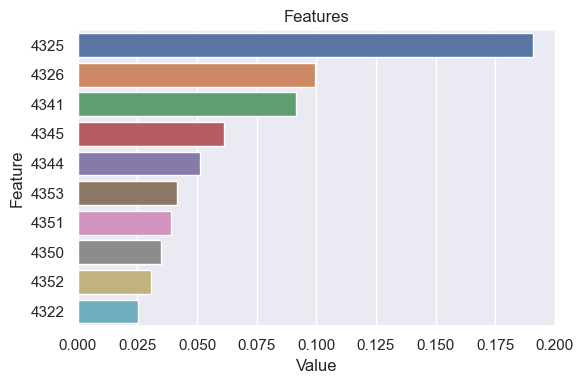

In [64]:
plot_importance(rf_final, X, num = 10)

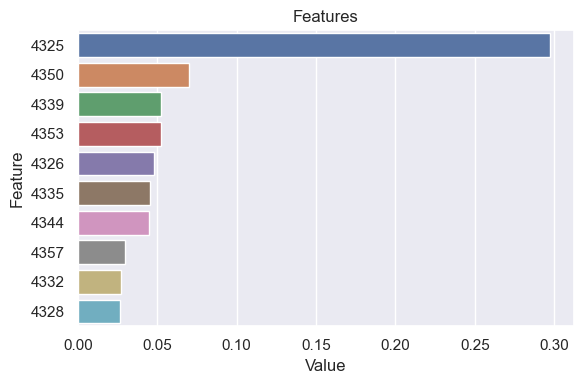

In [65]:
plot_importance(gbm_final, X, num = 10)

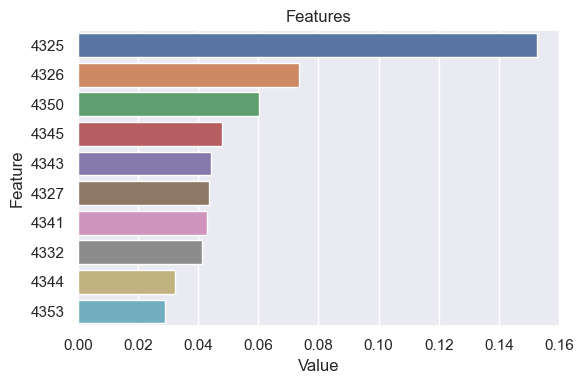

In [66]:
plot_importance(xgboost_final, X, num = 10)

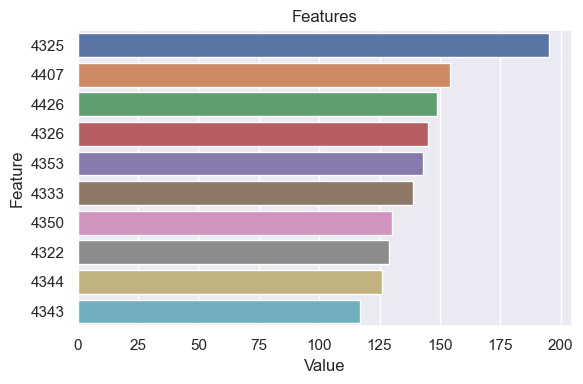

In [67]:
plot_importance(lgbm_final, X, num = 10)

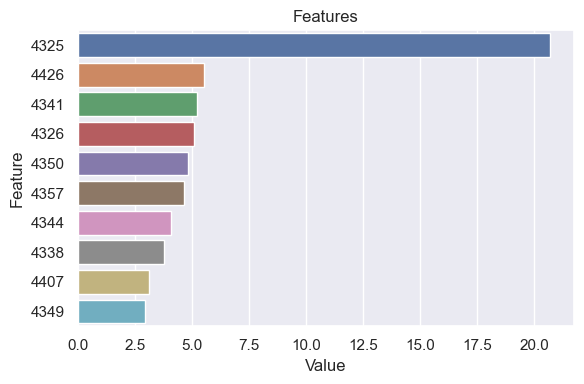

In [68]:
plot_importance(catboost_final, X, num = 10)